# Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from statsforecast import StatsForecast
from statsforecast.models import Naive, SeasonalNaive, SeasonalWindowAverage, AutoARIMA

sns.set(style="darkgrid")

C:\Users\brcalazans\AppData\Local\Programs\Python\Python310\lib\site-packages\statsforecast\core.py:21: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


# Datasets

In [3]:
df = pd.read_csv(r'C:\Users\brcalazans\Desktop\Pessoal\FIAP\Aulas\Fase 2\Tech Challenge\dados\Dados Históricos - Ibovespa.csv', sep=',')
df2 = pd.read_csv(r'C:\Users\brcalazans\Desktop\Pessoal\FIAP\Aulas\Fase 2\Tech Challenge\dados\Dados Históricos - Ibovespa (4).csv', sep=',')

In [4]:
df = pd.concat([df, df2], ignore_index=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5600 entries, 0 to 5599
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Data      5600 non-null   object 
 1   Último    5600 non-null   float64
 2   Abertura  5600 non-null   float64
 3   Máxima    5600 non-null   float64
 4   Mínima    5600 non-null   float64
 5   Vol.      5599 non-null   object 
 6   Var%      5600 non-null   object 
dtypes: float64(4), object(3)
memory usage: 306.4+ KB


# Tratamento dos Dados

In [6]:
df.loc[df['Vol.'].isnull()]

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
1258,10.02.2016,40.377,40.592,40.592,39.96,NaN,"-0,53%"


In [7]:
df = df.dropna()
df.isnull().sum()

Data        0
Último      0
Abertura    0
Máxima      0
Mínima      0
Vol.        0
Var%        0
dtype: int64

In [8]:
df['Var%'] = df['Var%'].str.replace("%", "")
df['Var%'] = df['Var%'].str.replace(",", ".")
df['Var%'] = df['Var%'].astype(float)

In [9]:
df['Vol.'] = df['Vol.'].str.replace(',', '.')

In [10]:
for _, row in df.iterrows():
    value = row['Vol.']
    try:
        if value[-1] == 'M':
            value = value.replace('M', '')
            value = float(value) * 1_000_000
        elif value[-1] == 'K':
            value = value.replace('K', '')
            value = float(value) * 1_000_00
        else:
            print('ERRO :', value)
            break
    except TypeError:
        print(value)
    df.loc[df.index == _, 'Vol.'] = value

In [11]:
df.head()

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,11.03.2021,114.984,112.782,115.127,112.776,12090000.0,1.96
1,10.03.2021,112.776,111.331,112.928,109.999,12510000.0,1.30
2,09.03.2021,111.331,110.611,112.525,109.343,12140000.0,0.65
3,08.03.2021,110.612,115.202,115.202,110.268,13700000.0,-3.98
4,05.03.2021,115.202,112.690,115.504,112.504,13250000.0,2.23


In [12]:
df['Vol.'] = round(df['Vol.'].astype(float))

In [13]:
# Convertendo variável 'Data' de object para Datetime
df['Data'] = df['Data'].str.replace('.', '-')
df['Data'] = pd.to_datetime(df['Data'], format="%d-%m-%Y")

In [14]:
df = df.set_index(df['Data'])

In [15]:
df = df.drop(columns=['Data'])

# Análise Exploratória de Dados

In [16]:
df.index

DatetimeIndex(['2021-03-11', '2021-03-10', '2021-03-09', '2021-03-08',
               '2021-03-05', '2021-03-04', '2021-03-03', '2021-03-02',
               '2021-03-01', '2021-02-26',
               ...
               '2021-03-25', '2021-03-24', '2021-03-23', '2021-03-22',
               '2021-03-19', '2021-03-18', '2021-03-17', '2021-03-16',
               '2021-03-15', '2021-03-12'],
              dtype='datetime64[ns]', name='Data', length=5599, freq=None)

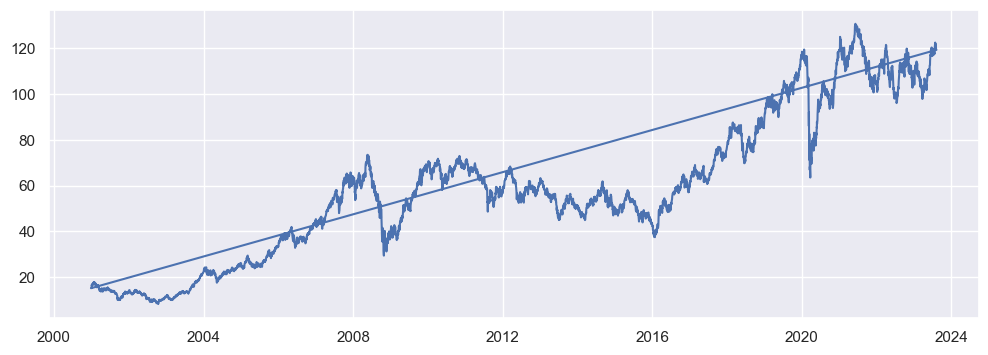

In [17]:
fig, ax = plt.subplots(figsize=(12,4))
plt.plot(df.index, df.Último)
plt.show()

In [18]:
df.head()

,Último,Abertura,Máxima,Mínima,Vol.,Var%
Data,,,,,,
2021-03-11,114.984,112.782,115.127,112.776,12090000.0,1.96
2021-03-10,112.776,111.331,112.928,109.999,12510000.0,1.30
2021-03-09,111.331,110.611,112.525,109.343,12140000.0,0.65
2021-03-08,110.612,115.202,115.202,110.268,13700000.0,-3.98
2021-03-05,115.202,112.690,115.504,112.504,13250000.0,2.23


In [19]:
df_decomposed = df[['Último']]
df_decomposed = df_decomposed.dropna()
df_decomposed = df_decomposed.sort_index()

In [20]:
df_decomposed.shape[0]

5599

In [21]:
resultados = seasonal_decompose(df_decomposed, period=1500)

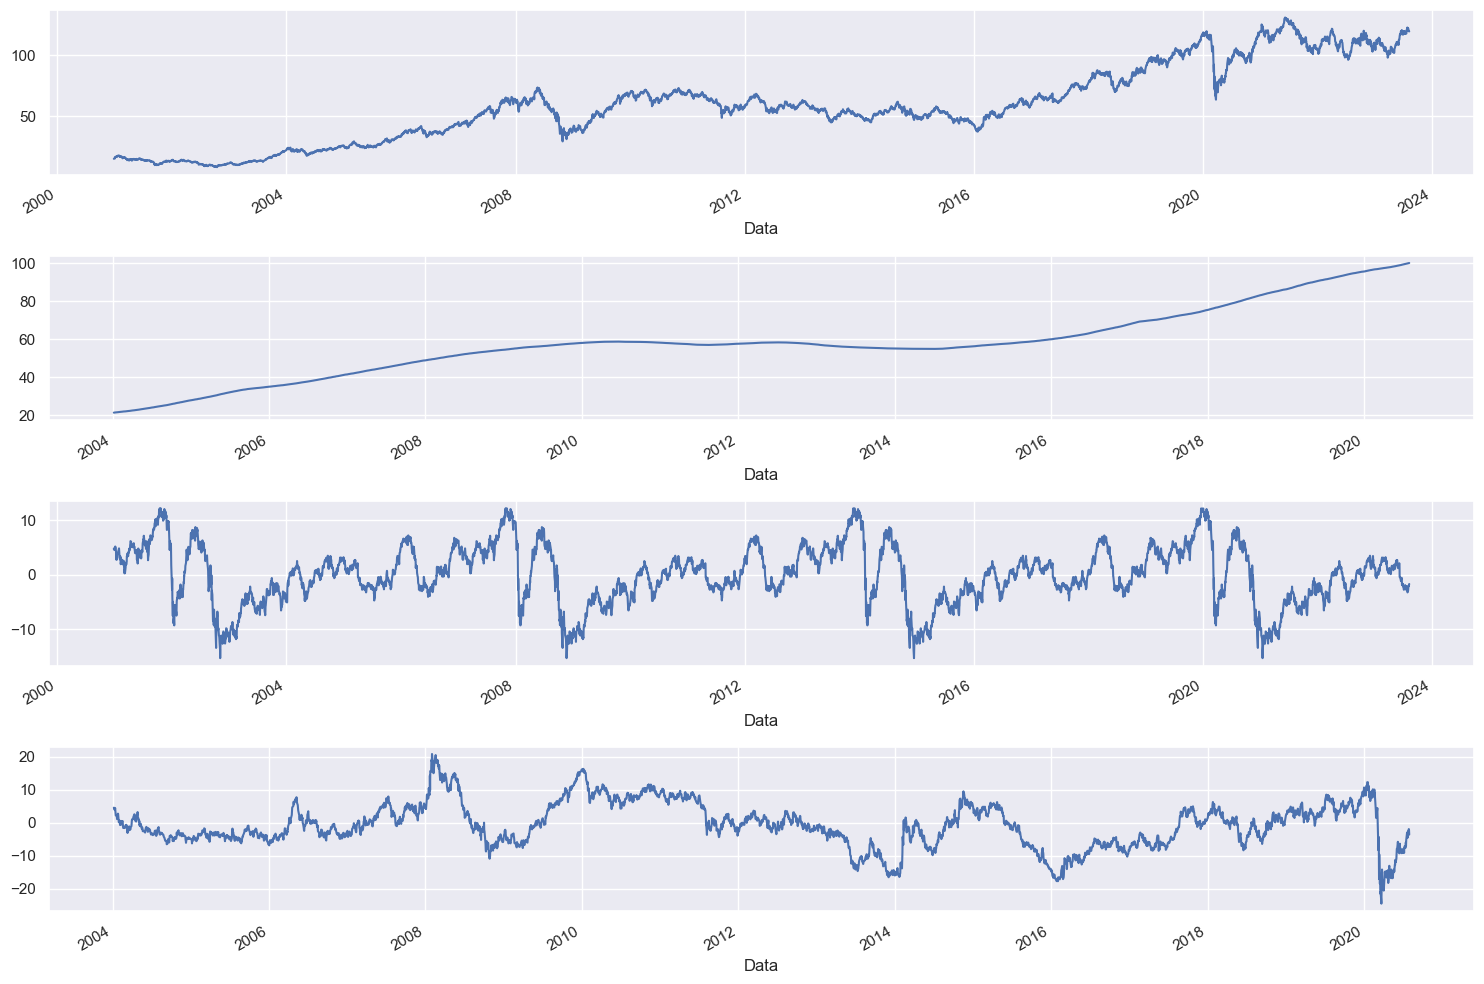

In [22]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15,10))

resultados.observed.plot(ax=ax1)
resultados.trend.plot(ax=ax2)
resultados.seasonal.plot(ax=ax3)
resultados.resid.plot(ax=ax4)

plt.tight_layout()

Conforme analisamos acima, os dados não são estacionários. Veremos a seguir como transformar os novos dados para que se tornem estacionários

In [23]:
X = df_decomposed.Último.values

In [24]:
result = adfuller(X)

In [25]:
print("Teste ADF")
print(f"Teste Estatístico: {result[0]}")
print(f"P-Value: {result[1]}")
print(f"Valores Críticos:")

for key, value in result[4].items():
    print(f"\t{key}: {value}")

Teste ADF
Teste Estatístico: -0.9221475600016155
P-Value: 0.7805914447257809
Valores Críticos:
	1%: -3.4315209874743893
	5%: -2.862057461806589
	10%: -2.5670454434892247


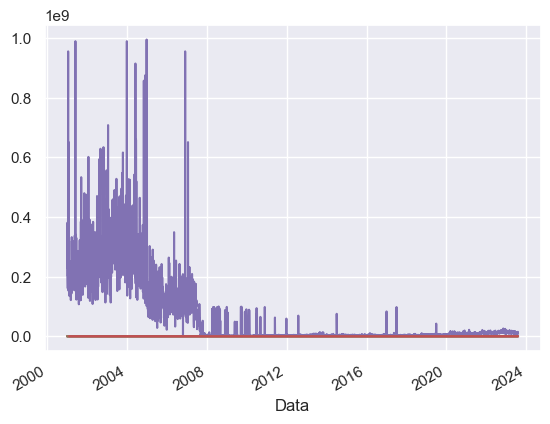

In [26]:
ma = df_decomposed.rolling(24).mean()
f, ax = plt.subplots()
df.plot(ax=ax, legend=False)
ma.plot(ax=ax, legend=False, color='r')
plt.show()

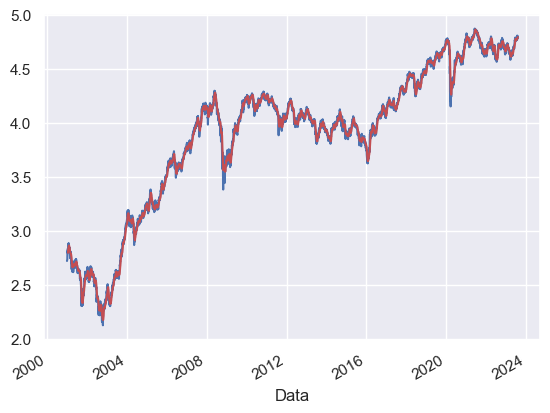

In [27]:
df_log = np.log(df_decomposed)
ma_log = df_log.rolling(12).mean()
f, ax = plt.subplots()
df_log.plot(ax=ax, legend=False)
ma_log.plot(ax=ax, legend=False, color='r')
plt.show()

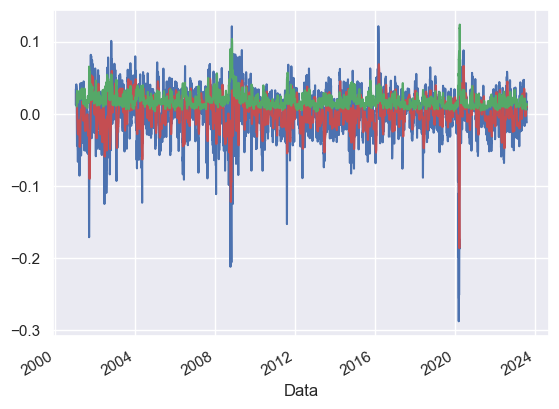

In [28]:
df_s = (df_log - ma_log).dropna()
ma_s = df_s.rolling(12).mean()
std  = df_s.rolling(12).std()

f, ax = plt.subplots()
df_s.plot(ax=ax, legend=False)
ma_s.plot(ax=ax, legend=False, color='r')
std.plot(ax=ax, legend=False, color='g')
plt.show()

In [29]:
X_s = df_s.Último.values

result_s = adfuller(X_s)

print("Teste ADF")
print(f"Teste Estatístico: {result_s[0]}")
print(f"P-Value: {result_s[1]}")
print(f"Valores Críticos:")

for key, value in result_s[4].items():
    print(f"\t{key}: {value}")

Teste ADF
Teste Estatístico: -14.388847336403844
P-Value: 8.894753982178351e-27
Valores Críticos:
	1%: -3.4315247740612116
	5%: -2.8620591347766497
	10%: -2.56704633406345


Teste ADF
Teste Estatístico: -19.76774453834243
P-Value: 0.0
Valores Críticos:
	1%: -3.431528160534219
	5%: -2.8620606309687067
	10%: -2.56704713053353


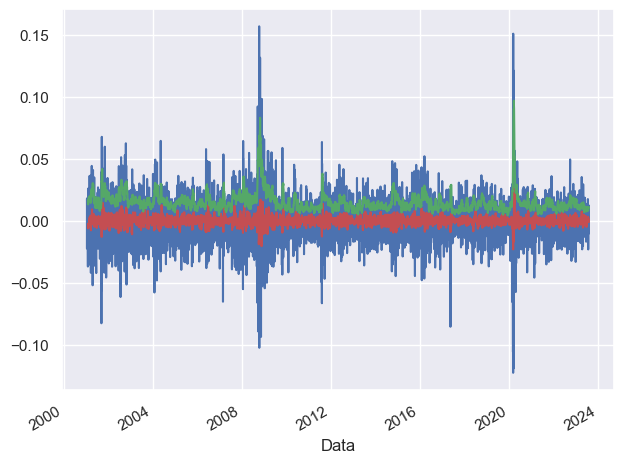

In [30]:
df_diff = df_s.diff(1)
ma_diff = df_diff.rolling(12).mean()
std_diff = df_diff.rolling(12).std()

f, ax = plt.subplots()
df_diff.plot(ax=ax, legend=False)
ma_diff.plot(ax=ax, legend=False, color='r')
std_diff.plot(ax=ax, legend=False, color='g')
plt.tight_layout()

X_diff = df_diff.Último.dropna().values

result_diff = adfuller(X_diff)

print("Teste ADF")
print(f"Teste Estatístico: {result_diff[0]}")
print(f"P-Value: {result_diff[1]}")
print(f"Valores Críticos:")

for key, value in result_diff[4].items():
    print(f"\t{key}: {value}")

In [31]:
lag_acf = acf(df_diff.dropna(), nlags=25)
lag_pacf = pacf(df_diff.dropna(), nlags=25)

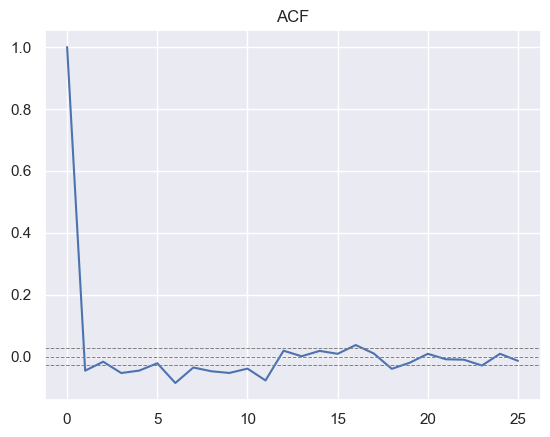

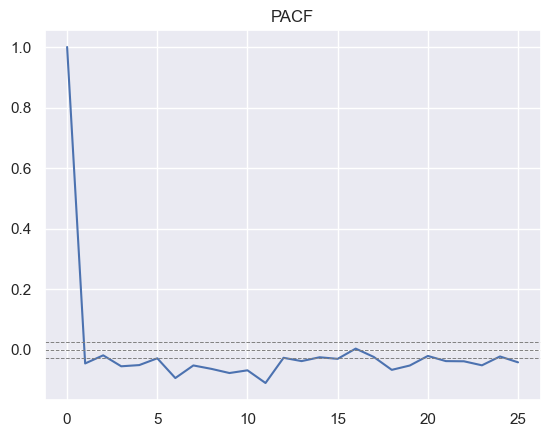

In [32]:
plt.plot(lag_acf)

plt.axhline(y=-1.96/(np.sqrt(len(df_diff) - 1)), linestyle="--", color='gray', linewidth=0.7)
plt.axhline(y=0/(np.sqrt(len(df_diff) - 1)), linestyle="--", color='gray', linewidth=0.7)
plt.axhline(y=1.96/(np.sqrt(len(df_diff) - 1)), linestyle="--", color='gray', linewidth=0.7)

plt.title("ACF")
plt.show()

plt.plot(lag_pacf)

plt.axhline(y=-1.96/(np.sqrt(len(df_diff) - 1)), linestyle="--", color='gray', linewidth=0.7)
plt.axhline(y=0/(np.sqrt(len(df_diff) - 1)), linestyle="--", color='gray', linewidth=0.7)
plt.axhline(y=1.96/(np.sqrt(len(df_diff) - 1)), linestyle="--", color='gray', linewidth=0.7)

plt.title("PACF")
plt.show()

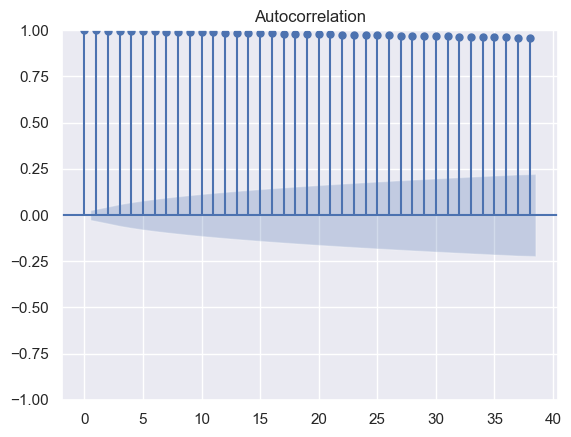

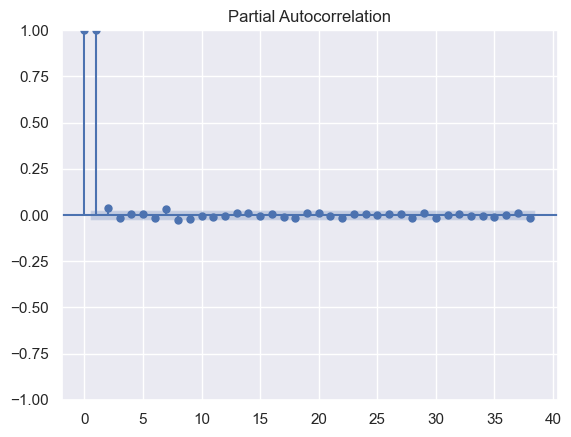

In [33]:
plot_acf(df_decomposed.Último)
plot_pacf(df_decomposed.Último)
plt.show()

In [64]:
df_x = df_decomposed.reset_index()
df_x['unique_id'] = 'Ibovespa'
df_x = df_x.rename(columns={"Data": "ds", "Último": "y"})
df_x

,ds,y,unique_id
0,2000-12-27,15.186,Ibovespa
1,2000-12-28,15.259,Ibovespa
2,2001-01-02,15.425,Ibovespa
3,2001-01-03,16.599,Ibovespa
4,2001-01-04,16.675,Ibovespa
...,...,...,...
5594,2023-08-01,121.248,Ibovespa
5595,2023-08-02,120.859,Ibovespa
5596,2023-08-03,120.586,Ibovespa
5597,2023-08-04,119.508,Ibovespa


In [47]:
treino = df_x.loc[(df_x['ds'] > '2019-01-01') &(df_x['ds'] < '2023-01-01')]
valid  = df_x.loc[(df_x['ds'] >= '2023-01-01') & (df_x['ds'] < '2023-05-13')]
h = valid['ds'].nunique()

In [48]:
def wmape(y_true, y_pred):
    return np.abs(y_true-y_pred).sum() / np.abs(y_true).sum()

In [53]:
model_a = StatsForecast(models=[AutoARIMA(season_length=7)], freq='D', n_jobs=-1)
model_a.fit(treino, me)

forecast_dfa = model_a.predict(h=h, level=[90])
forecast_dfa = forecast_dfa.reset_index().merge(valid, on=['ds', 'unique_id'], how='left')

wmape4 = wmape(forecast_dfa['y'].values, forecast_dfa['AutoARIMA'].values)
print(f"WMAPE: {wmape4:.2%}")

<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast


WMAPE: nan%


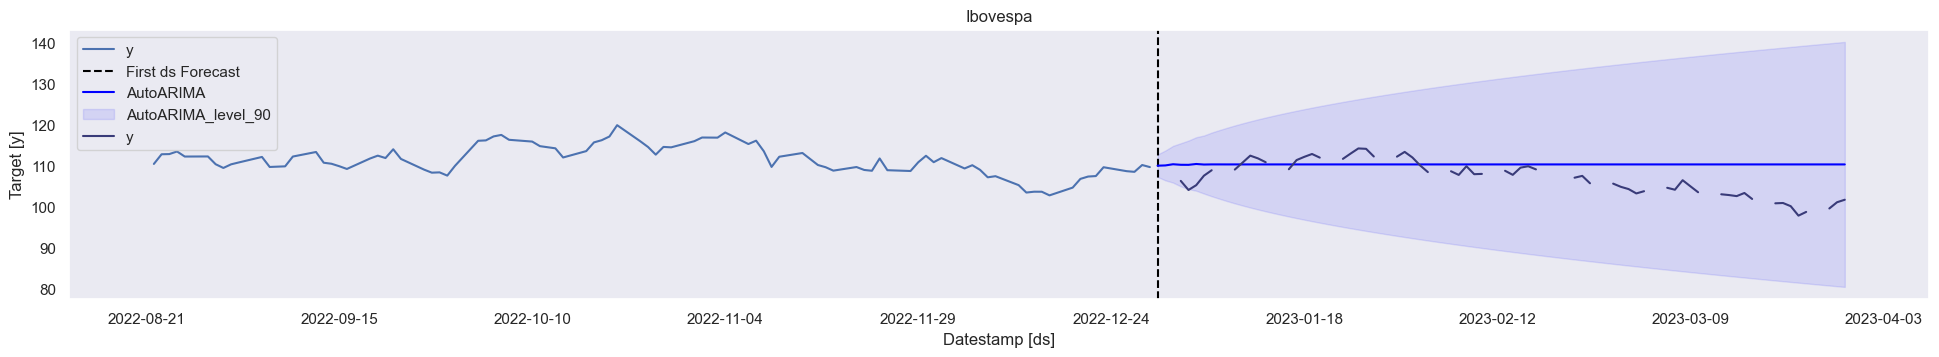

In [55]:
model_a.plot(treino, forecast_dfa, level=[90], unique_ids=['Ibovespa'], engine="matplotlib", max_insample_length=90)

In [59]:
forecast_dfa

,unique_id,ds,AutoARIMA,AutoARIMA-lo-90,AutoARIMA-hi-90,y
0,Ibovespa,2022-12-30,110.076157,107.342308,112.810005,NaN
1,Ibovespa,2022-12-31,110.137787,106.515732,113.759834,NaN
2,Ibovespa,2023-01-01,110.426300,105.955055,114.897545,NaN
3,Ibovespa,2023-01-02,110.294914,105.055534,115.534302,106.376
4,Ibovespa,2023-01-03,110.282166,104.382172,116.182167,104.166
...,...,...,...,...,...,...
85,Ibovespa,2023-03-25,110.383224,81.269043,139.497391,NaN
86,Ibovespa,2023-03-26,110.383224,81.096001,139.670441,NaN
87,Ibovespa,2023-03-27,110.383224,80.923973,139.842468,99.670
88,Ibovespa,2023-03-28,110.383224,80.752937,140.013504,101.185
